# Pipeline
* load data
* heal data and remove outliers
* making data for item_details which contains all information about all items
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* make column for item_prices and fill it entirely
* merge shops/items/cats to the matrix
* add target lag features
* add months since last sale/months since first sale features
* add lag variables based on item_prices
* add price lag features
* add month
* add days
* cut first year and drop columns which can not be calculated for the test set
* add mean encoded features
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from matplotlib.pyplot import figure
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'competitive-data-science-predict-future-sales.zip', 'items.csv', 'item_categories.csv', 'Predict Future sales Part-1.ipynb', 'Predict Future Sales-Part 2.ipynb', 'sales_train.csv.gz', 'sales_train_v2.csv', 'sample_submission.csv', 'sample_submission.csv.gz', 'shops.csv', 'test.csv', 'test.csv.gz']


In [2]:
#Defining function which helps to reduce size of dataframes, so that kernel does not die
def reduce_size(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [3]:
#Loading given dataframes
shops = pd.read_csv("shops.csv")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train_v2.csv")
items = pd.read_csv("items.csv")
test = pd.read_csv("test.csv")

# Preliminary Analysis

One important pre-liminary analysis is to check for duplicated rows in train and test set, if present remove them.

In [4]:
# Check duplicated rows in train set
df = sales_train[sales_train.duplicated()]  # checks duplicate rows considering all columns
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


Above dataframe shows that there are 6 different rows which are occurring >1 times.

In [5]:
# to check how many times 1st row of above df is repeating
df.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0


In [6]:
#deleting df as it is not required elsewhere, it helps to reduce size of kernel
del df
gc.collect();

In [7]:
sales_train[(sales_train.date == "05.01.2013") & (sales_train.item_id==20130) & (sales_train.shop_id==54)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
76962,05.01.2013,0,54,20130,149.0,1.0


It is repeating 2 times. We need to remove all such repetitions keeping only 1 of such occurence.

In [8]:
#Dropping duplicates and keeping first occurence only
sales_train.drop_duplicates(keep = 'first', inplace = True) # keep: keeps first occurence as original, removes rest

Test set has no duplicates(checked but not shown here).

In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Now for each item, we maintain record of its price by taking mean of each item from data.

In [10]:

item_prices = sales_train.groupby('item_id').agg({'item_price':'mean'}).reset_index()
item_prices = pd.merge(item_prices, items, on = ['item_id'],how = 'left').drop('item_name',axis=1)
print(item_prices.head())

   item_id  item_price  item_category_id
0        0        58.0                40
1        1      4490.0                76
2        2        58.0                40
3        3        79.0                40
4        4        58.0                40


Checking total number of distinct shops in train and test set to check uniqueness.

In [11]:
a = sales_train.shop_id.unique()
b = test.shop_id.unique()
l=0
for i in b:
    if i not in a:
        l = l +1
print(l)
print("total distinct shops in train set: ",len(a))
print("total distinct shops in test set: ",len(b))
print("Number of shops present in test set but not in train set: ", l)

0
total distinct shops in train set:  60
total distinct shops in test set:  42
Number of shops present in test set but not in train set:  0


Similar for items

In [12]:
a = sales_train.item_id.unique()
b = test.item_id.unique()
l=0
for i in b:
    if i not in a:
        l = l +1
print("total distinct items in train set: ",len(a))
print("total distinct items in test set: ",len(b))
print("Number of distinct items present in test set but not in train set: ", l)

del a 
del b
gc.collect();

total distinct items in train set:  21807
total distinct items in test set:  5100
Number of distinct items present in test set but not in train set:  363


In [13]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Making record of item prices for each item which is initially present in training data. This we will later use to merge prices data with all combinations of item X shop, and fill price data of train set.

In [15]:
item_prices_train_data = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'mean'}).reset_index()
item_prices_train_data.head()

,date_block_num,shop_id,item_id,item_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [17]:
print(shops.columns)
print(item_categories.columns)
print(sales_train.columns)
print(items.columns)
print(test.columns)

Index(['shop_name', 'shop_id'], dtype='object')
Index(['item_category_name', 'item_category_id'], dtype='object')
Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
Index(['ID', 'shop_id', 'item_id'], dtype='object')


In [18]:
# insights
print('max. number of items sold {} and min are {}: '.format(sales_train['item_cnt_day'].max(),sales_train['item_cnt_day'].min()))
print('start date is {} and end date is {}'.format(sales_train['date'].min(), sales_train['date'].max()))
#note max date is actually October, 2015, python is not checking till last row

max. number of items sold 2169.0 and min are -22.0: 
start date is 01.01.2013 and end date is 31.12.2014


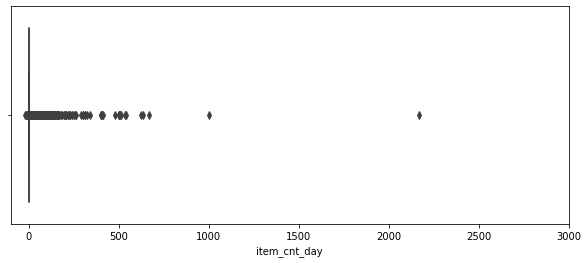

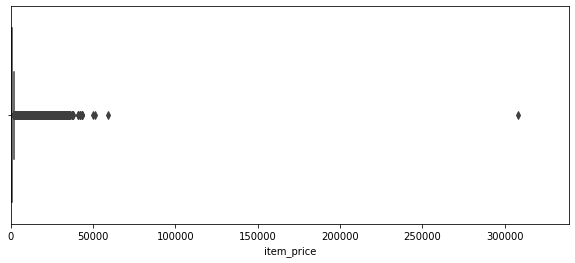

In [19]:
#checking the outliers in sales_train
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price)

In [20]:
#removing outliers
sales_train = sales_train[sales_train.item_price<50000]
sales_train = sales_train[sales_train.item_cnt_day<1001]

In [21]:
#number of rows having negative price of an item
print((sales_train.item_price<0).sum())
# fill it with median
#first find to which shop, item_id, month it belongs
sales_train[sales_train.item_price<0]

1


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [22]:
# filing negative price of item by its median value
median = sales_train[(sales_train.shop_id == 32) & (sales_train.item_id==2973) & (sales_train.date_block_num==4) 
            & (sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

In [23]:
# getting unique shop_id and unique item_id
shop_unique = sales_train['shop_id'].unique()
item_id_unique = sales_train['item_id'].unique()
print("Number of unique  shops are {} and number of unique items are {}".format(len(shop_unique),
      len(item_id_unique)))


Number of unique  shops are 60 and number of unique items are 21805


In [24]:
shops_len = shops.groupby('shop_name')['shop_id'].nunique()
#print(shops_len);

# EDA

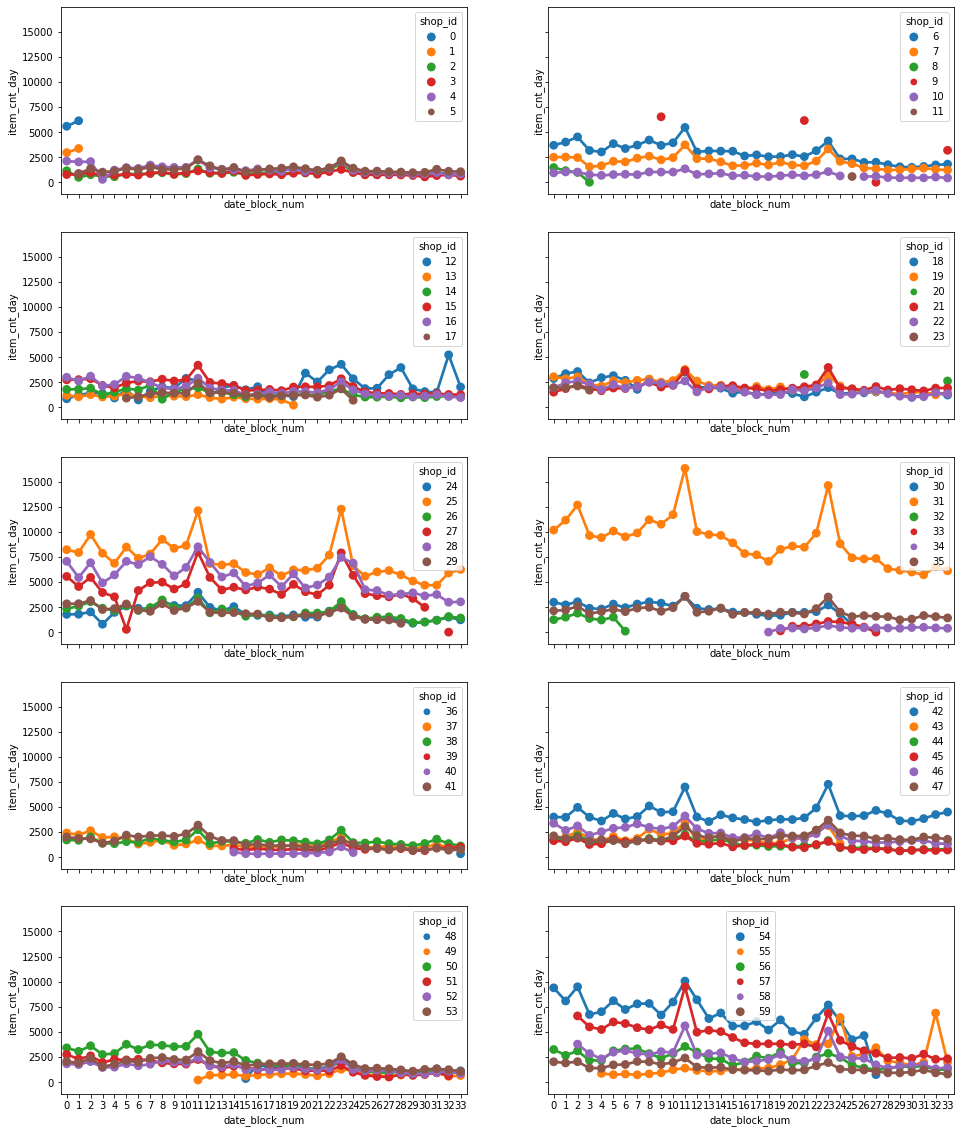

In [25]:
grouped = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = math.ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

There are total 33 months, we are seeing spike at year end

There is slight seasonality in some item_categories but not in all categories.

In [26]:
print('Number of unique items in test data:', test.item_id.nunique())
print('Number of items present in test set but not in train set:',len(list(set(test.item_id) - set(test.item_id).intersection(set(sales_train.item_id)))))

Number of unique items in test data: 5100
Number of items present in test set but not in train set: 363


NOTE: We can delete items of train set which are not present in test set, because we are not testing them anyway. But even if we keep  it should not affect the performace. So, I am not removing them.

Now making a dataframe which contains all information about all items.

In [27]:
item_details = pd.merge(item_categories, items[['item_id', 'item_category_id']], on ='item_category_id',how='left')
item_details.head()

,item_category_name,item_category_id,item_id
0,PC - Гарнитуры/Наушники,0,5441
1,PC - Гарнитуры/Наушники,0,16255
2,PC - Гарнитуры/Наушники,0,16256
3,PC - Гарнитуры/Наушники,0,16257
4,Аксессуары - PS2,1,5606


In [28]:
item_grp = item_details['item_category_name'].apply(lambda x: str(x).split(' ')[0])
subtype = item_details['item_category_name'].str.split('-')
subtype = subtype.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_grp = pd.Categorical(item_grp).codes     # converting to label encoded feature
subtype = pd.Categorical(subtype).codes
item_details['item_group'] = item_grp
item_details['subtype'] = subtype
item_details  = item_details.drop(['item_category_name'],axis=1)

In [29]:
#filling item details dataframe with item prices. First by adding items from training set
# then filing NaN prices (obtained from test set) with mean
abc = pd.merge(item_details,item_prices, on = ['item_id','item_category_id'], how='left')
item_price_avg_subtype = abc.groupby(['item_group','subtype']).agg({'item_price':'mean'}).reset_index()
na = abc[abc.item_price.isnull()]
abc = abc[~abc.item_price.isnull()]
na.drop('item_price',axis=1, inplace=True)
na = pd.merge(na,item_price_avg_subtype, on=['item_group','subtype'], how = 'left')   #going granular to obtain better estimate of item prices
item_details = pd.concat([abc, na],axis=0)
item_details.head()

,item_category_id,item_id,item_group,subtype,item_price
1,0,16255,0,29,93.0
2,0,16256,0,29,22.4
3,0,16257,0,29,148.0
4,1,5606,1,9,148.0
5,1,5740,1,9,283.0


In [30]:
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train_shops = sales_train.shop_id.unique()
train_items = sales_train.item_id.unique()

In [31]:
#rolling train data at month level
sales_monthly = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
sales_monthly.columns = ['item_cnt_month']
sales_monthly.reset_index(inplace=True)

#sales_monthly = pd.merge(sales_train, group, on=['date_block_num','shop_id','item_id'], how='left')
sales_monthly['item_cnt_month'] = (sales_monthly['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

Making matrix containing all combinations of shop X item_id within a month. This is useful in the sense that it replicates test data distribution, i.e. some shop X item would be new(not appearing in previous months) and some having item_cnt_month == 0. test data will also have some new items which have not appeared before so shop X item data is not available and for new items item_cnt might be 0.

In [32]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_monthly[sales_monthly.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [33]:
matrix.shape

(10913756, 3)

Merging item_cnt_month data with matrix, price data at 'date_block_num' X 'shop_id' X 'item_id' which was in train data will be there and rest will be missing values.

In [34]:
sales_monthly = pd.merge(matrix,sales_monthly, on = ['date_block_num','shop_id','item_id'], how = 'left')
sales_monthly.shape

(10913756, 4)

In [35]:
del matrix
del abc
del na
gc.collect();

In [36]:
# making test data similar to train data
test = test.drop('ID',axis=1)
test['date_block_num']=34

In [37]:
# joining train and test data to make feature engineering easy
cols = ['date_block_num','shop_id','item_id']
all_data = pd.concat([sales_monthly, test], ignore_index=True, sort=False, keys=cols)
all_data.fillna(0, inplace=True) # for 34th month and missing values which occured during combination of shop X item

Now merging enitre data to have item_price also, if it is not present then taken from item_details table which was made earlier. This is something unique which is not done in other kernels.

In [38]:
#adding price data at date_block level from original sales data
all_data = pd.merge(all_data,item_prices_train_data, on = ['date_block_num','shop_id','item_id'], how = 'left')
#for items for which we don't have price data, filing it with price value created using means and then appending
all_data_non_null = all_data[~all_data.item_price.isnull()]
abc = all_data[all_data.item_price.isnull()]
abc.drop('item_price',axis=1,inplace=True)
abc = pd.merge(abc, item_details[['item_id','item_price']], on =['item_id'],how='left')

del all_data
gc.collect();

all_data = pd.concat([all_data_non_null,abc]).sort_values(by=['date_block_num','shop_id','item_id'])
item_details.drop('item_price',axis=1, inplace=True)
all_data = pd.merge(all_data, item_details, on =['item_id'],how='left')


In [39]:
#Deleting intermediate data to reduce kernel size
del all_data_non_null
del abc
del item_grp
del subtype
del item_prices_train_data
del sales_monthly
gc.collect();

Some shops are same(insight taken from other kernels).

In [40]:
# Pre-processing with Shop_name
all_data = pd.merge(all_data, shops[['shop_name','shop_id']], on ='shop_id',
                 how='left')
#if we see names of shop, they are all in Russian language. But there are few shops having same names but 
#extra some symbol has been added to them. we will make that same.

# Якутск Орджоникидзе, 56
all_data.loc[all_data.shop_id == 0, 'shop_id'] = 57
all_data.loc[all_data.shop_id == 0, 'shop_name'] = 'Якутск Орджоникидзе, 56'
test.loc[test.shop_id == 0, 'shop_id']=57
# Якутск ТЦ "Центральный"
all_data.loc[all_data.shop_id == 1, 'shop_id'] = 58
all_data.loc[all_data.shop_id == 1, 'shop_name'] = 'Якутск ТЦ "Центральный"'
test.loc[test.shop_id == 1, 'shop_id']=58
# Жуковский ул. Чкалова 39м²
all_data.loc[all_data.shop_id == 10, 'shop_id'] = 11
all_data.loc[all_data.shop_id == 10, 'shop_name'] = 'Жуковский ул. Чкалова 39м²'
test.loc[test.shop_id == 10, 'shop_id']= 11

city = all_data['shop_name'].apply(lambda x: str(x).split(' ')[0])
city = pd.Categorical(city).codes
all_data['city'] = city
all_data  = all_data.drop(['shop_name'],axis=1)
print(all_data.shape)
all_data.tail()

(11127956, 9)


,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,item_group,subtype,city
11127951,34,59,22162,0.0,381.663429,40,7,4,31
11127952,34,59,22163,0.0,164.682958,40,7,4,31
11127953,34,59,22164,0.0,713.525809,37,7,1,31
11127954,34,59,22166,0.0,150.000000,54,8,61,31
11127955,34,59,22167,0.0,297.686490,49,8,39,31


In [41]:
#Reducing size of main dataframe
total_before_opti = sum(all_data.memory_usage())
reduce_size(all_data);

print("Memory usage before optimization :", str(round(total_before_opti/1000000000,2))+'GB')
print("Memory usage after optimization :", str(round(sum(all_data.memory_usage())/1000000000,2))+'GB')
print("We reduced the dataframe size by",str(round(((total_before_opti - sum(all_data.memory_usage())) /total_before_opti)*100,2))+'%')

Memory usage before optimization : 0.59GB
Memory usage after optimization : 0.28GB
We reduced the dataframe size by 52.83%


# Creating Lag Variables

In [42]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]

    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        #df.loc[i*, col+'_lag_'+str(i)] = shifted[col+'_lag_'+str(i)]
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        del shifted
    del tmp
    gc.collect();
    return df

1. Lag based on average items sold for different combinations of each date_block_num/shop_id/category

In [43]:
group1 = all_data.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group1.columns = ['db_avg_items_sold']
group1.reset_index(inplace=True)

group2 = all_data.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group2.columns = ['db_shop_avg_items_sold']
group2.reset_index(inplace=True)

group3 = all_data.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group3.columns = ['db_cat_avg_items_sold']
group3.reset_index(inplace=True)

group4 = all_data.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
group4.columns = ['db_shop_cat_avg_items_sold']
group4.reset_index(inplace=True)

group5 = all_data.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group5.columns = ['db_item_id_items_sold']
group5.reset_index(inplace=True)

group6 = all_data.groupby(['date_block_num','shop_id','city']).agg({'item_cnt_month':['mean']})
group6.columns = ['db_shop_city_avg_items_sold']
group6.reset_index(inplace=True)

group7 = all_data.groupby(['date_block_num','city']).agg({'item_cnt_month':['mean']})
group7.columns = ['db_city_avg_items_sold']
group7.reset_index(inplace=True)

group8 = all_data.groupby(['date_block_num','item_category_id','city']).agg({'item_cnt_month':['mean']})
group8.columns = ['db_cat_city_avg_items_sold']
group8.reset_index(inplace=True)

In [44]:
#Merging lag_features with main data

# group-1
all_data = pd.merge(all_data, group1, on = ['date_block_num'], how = 'left')
#all_data['db_avg_items_sold'] = all_data['db_avg_items_sold']
all_data = lag_feature(all_data, [1], 'db_avg_items_sold')
all_data.drop('db_avg_items_sold',axis=1,inplace=True)
del group1
gc.collect();
#reduce_size(all_data)

# group-2
all_data = pd.merge(all_data, group2, on = ['date_block_num','shop_id'], how = 'left')
#all_data['db_shop_avg_items_sold'] = all_data['db_shop_avg_items_sold']
all_data = lag_feature(all_data, [1], 'db_shop_avg_items_sold')                                 # initially took 3,6,12 lag but they were not important features, checked after running model
all_data.drop('db_shop_avg_items_sold',axis=1,inplace=True)
del group2
gc.collect();
#reduce_size(all_data)

# group-3
all_data = pd.merge(all_data, group3, on = ['date_block_num','item_category_id'], how = 'left')
#all_data['db_cat_avg_items_sold'] = all_data['db_cat_avg_items_sold']
all_data = lag_feature(all_data, [1,2], 'db_cat_avg_items_sold')
all_data.drop('db_cat_avg_items_sold',axis=1,inplace=True)
del group3
gc.collect();
reduce_size(all_data);

# group-4
all_data = pd.merge(all_data, group4, on = ['date_block_num','shop_id','item_category_id'], how = 'left')
#all_data['db_shop_cat_avg_items_sold'] = all_data['db_shop_cat_avg_items_sold']
all_data = lag_feature(all_data, [1,2,3], 'db_shop_cat_avg_items_sold')
all_data.drop('db_shop_cat_avg_items_sold',axis=1,inplace=True)
del group4
gc.collect();
#reduce_size(all_data)

# group-5
all_data = pd.merge(all_data, group5, on = ['date_block_num','item_id'], how = 'left')
#all_data['db_cat_subtype_avg_items_sold'] = all_data['db_cat_subtype_avg_items_sold']
all_data = lag_feature(all_data, [1,2,3,6,12], 'db_item_id_items_sold')
all_data.drop('db_item_id_items_sold',axis=1,inplace=True)

del group5
gc.collect();

# group-6
all_data = pd.merge(all_data, group6, on = ['date_block_num','shop_id','city'], how = 'left')
#all_data['db_shop_city_avg_items_sold'] = all_data['db_shop_city_avg_items_sold']
all_data = lag_feature(all_data, [1,2,3,6,12], 'db_shop_city_avg_items_sold')
all_data.drop('db_shop_city_avg_items_sold',axis=1,inplace=True)
del group6
gc.collect();

# group-7
all_data = pd.merge(all_data, group7, on = ['date_block_num','city'], how = 'left')
#all_data['db_city_avg_items_sold'] = all_data['db_city_avg_items_sold']
all_data = lag_feature(all_data, [1], 'db_city_avg_items_sold')                                  # initially took 3,6,12 lag but they were not important features, checked after running model
all_data.drop('db_city_avg_items_sold',axis=1,inplace=True)
del group7
gc.collect();

# group-8
all_data = pd.merge(all_data, group8, on = ['date_block_num','item_category_id','city'], how = 'left')
#all_data['db_city_avg_items_sold'] = all_data['db_city_avg_items_sold']
all_data = lag_feature(all_data, [1], 'db_cat_city_avg_items_sold')                            # initially took 2,3,6,12 lag but they were not important features, checked after running model
all_data.drop('db_cat_city_avg_items_sold',axis=1,inplace=True)
reduce_size(all_data);

del group8
gc.collect();

2. Lag features based on min/max of item_cnt for date_block X shop X item 

In [45]:
# Creating more features
item_max_cnt = all_data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_month':np.max})
item_min_cnt = all_data.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_month':np.min})
item_max_cnt.columns = ['max_cnt']
item_min_cnt.columns = ['min_cnt']
item_max_cnt.reset_index(inplace=True)
item_min_cnt.reset_index(inplace=True)


all_data = pd.merge(all_data, item_max_cnt, on = ['date_block_num','shop_id','item_id'], how = 'left')
all_data = pd.merge(all_data, item_min_cnt, on = ['date_block_num','shop_id','item_id'], how = 'left')

del item_max_cnt
del item_min_cnt
gc.collect();

all_data = lag_feature(all_data, [1,3,6], 'max_cnt') 
all_data = lag_feature(all_data, [1,3,6], 'min_cnt') 

all_data.drop(['max_cnt','min_cnt'], axis=1, inplace=True)

In [46]:
#Adding month variable, it will also help in mapping holidays, number of days etc
all_data['month'] = (all_data['date_block_num'] % 12)+1    #date_block_num starts from 1

3. Lag features based on item_prices and revenue

Price feature is also an important factor to consider if we are interested in seeing the sales. If month on month the price of the item is going up then ppl are less likely to buy it thereby decreasing the sales.
We will make a delta feature which will account for change in price of item from previous month.

In [47]:
training_data_prices = all_data[(all_data.date_block_num<34)]
# we don't  need for date_block ==34, because we are making only lag features so for last month, 
# lag can be created using previous months data

price_group = training_data_prices.groupby(['date_block_num', 'item_id']).agg({'item_price':'mean'})
price_group.columns = ['db_item_avg_price']

#del training_data_prices
#gc.collect();

all_data = pd.merge(all_data,price_group, on = ['date_block_num', 'item_id'], how='left')


del price_group
gc.collect();
# will fill price data for test set too

all_data = lag_feature(all_data, [1,3,6,12], 'db_item_avg_price')
lags = [1,3,6,12]
for i in lags:
    all_data['delta_price_lag_'+str(i)] = (all_data['db_item_avg_price'] - all_data['db_item_avg_price_lag_' + str(i)])/(all_data['db_item_avg_price'])

    
#making revenue features
all_data['revenue'] = all_data['item_cnt_month']*all_data['item_price']
revenue_shop = all_data.groupby(['date_block_num','shop_id','item_id']).agg({'revenue':'sum'})
revenue_shop.columns = ['revenue_shop']
all_data = pd.merge(all_data,revenue_shop, on = ['date_block_num','shop_id','item_id'], how='left')  # will fill price data for test set too


all_data = lag_feature(all_data, [1,2], 'revenue_shop')
all_data = lag_feature(all_data, [1], 'revenue')  # initialy took multiple lags, but after seeing feature importance
                                                    #taking only lag1

all_data.drop(['db_item_avg_price','revenue','revenue_shop'],axis=1,inplace=True)

More features:

In [48]:
all_data['item_shop_months_since_first_sale'] = all_data['date_block_num'] - all_data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
all_data['item_months_since_first_sale'] = all_data['date_block_num'] - all_data.groupby('item_id')['date_block_num'].transform('min')

In [49]:
reduce_size(all_data);

Add last sales feature
1. Item+ shop combination,months since last sale
2. Item, months since last sale

In [50]:
cache = {}
all_data['item_shop_last_sale'] = 0
all_data['item_shop_last_sale'] = all_data['item_shop_last_sale'].astype(np.int8)
for idx, row in all_data.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        all_data.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

del cache
gc.collect();

In [51]:
# was killing the kernel because of size
'''
cache = {}
all_data['item_last_sale'] = 0
all_data['item_last_sale'] = all_data['item_last_sale'].astype(np.int8)
for idx, row in all_data.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            all_data.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num 
            
del cache
gc.collect();
'''

"\ncache = {}\nall_data['item_last_sale'] = 0\nall_data['item_last_sale'] = all_data['item_last_sale'].astype(np.int8)\nfor idx, row in all_data.iterrows():    \n    key = row.item_id\n    if key not in cache:\n        if row.item_cnt_month!=0:\n            cache[key] = row.date_block_num\n    else:\n        last_date_block_num = cache[key]\n        if row.date_block_num>last_date_block_num:\n            all_data.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num\n            cache[key] = row.date_block_num \n            \ndel cache\ngc.collect();\n"

More lag features!!

In [52]:
lags = [1,3,6,12]
def select_first_non_null(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
all_data['delta_price_lag'] = all_data.apply(select_first_non_null, axis=1).astype(np.float16)
all_data['delta_price_lag'].fillna(0, inplace=True)

all_data.item_cnt_month = all_data.item_cnt_month.astype('float32')

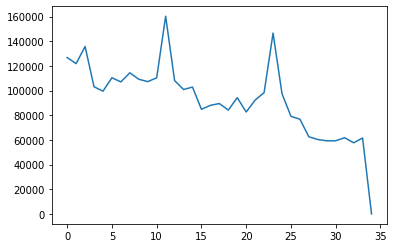

In [53]:
#Visualize item sales for each calendar month
a = all_data.groupby('date_block_num').agg({'item_cnt_month':'sum'})
plt.plot(a)

#del a 
#gc.collect();

From city name (first word of shop name, translated)  we observe that it is data of Russia. So adding new feature regarding Number of national holidays + religious holidays and other, in Russia for each month.
Source: https://www.timeanddate.com/holidays/russia/#!hol=25231673
NOTE: Seeing the month over month trend of items sales, the sales shoot up in Dec as compared to november probably due to year end. Although in the given source holiays in Dec are 1 only, but due  to sales I am making it close to Jan holidays manually.

In [54]:
holidays_dict1 = {1 : 7, 2:3, 3:2, 4:2, 5:7, 6:3,7:0, 8:1, 9:3, 10:0, 11:2, 12:6}  #source: mentioned above
holidays_dict2 = {1 : 6, 2:3, 3:2, 4:8, 5:3, 6:3,7:2, 8:8, 9:4, 10:8, 11:5, 12:4}  #source: from other kernels
num_days_dict = {1:31 ,2:28 ,3:31,4:30 ,5:31,6: 30,7:31,8:31,9:30,10:31,11:30,12:31}
is_dec = {1:0 ,2:0 ,3:0,4:0 ,5:0,6: 0,7:0,8:0,9:0,10:0,11:0,12:1}
'''
# the following feature captures inflation rate starting from Jan 2013, Source: Internet
inflation_cpi = {1: 7.07, 2: 7.28, 3: 7.02, 4: 7.23, 5: 7.38, 6: 6.88, 7: 6.45, 8: 6.49, 9: 6.13, 10: 6.25, 11: 6.5, 12: 6.45, 13: 6.05, 14: 6.19, 15: 6.91, 16: 7.33, 17: 7.59
                 ,18: 7.8, 19: 7.45, 20: 7.55, 21: 8.03, 22: 8.29, 23: 9.06, 24: 11.36, 25: 14.97, 26: 16.71, 27: 16.93, 28: 16.42, 29: 15.78, 30: 15.29, 31: 15.64, 32: 15.77, 33: 15.68
                 , 34: 15.59, 35: 14.98, 36: 12.91}
'''
all_data['num_holidays'] = all_data['month'].map(holidays_dict2) #giving better performance
all_data['num_days'] = all_data['month'].map(num_days_dict)
#all_data['inflation_cpi'] = all_data['date_block_num'].map(inflation_cpi)
all_data['is_dec'] = all_data['month'].map(is_dec)
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,item_group,subtype,city,db_avg_items_sold_lag_1,...,revenue_shop_lag_1,revenue_shop_lag_2,revenue_lag_1,item_shop_months_since_first_sale,item_months_since_first_sale,item_shop_last_sale,delta_price_lag,num_holidays,num_days,is_dec
0,0,57,19,0.0,28.000000,40,7,4,0,NaN,...,NaN,NaN,NaN,0,0,0,0.0,6,31,0
1,0,57,27,0.0,1461.228516,19,5,10,0,NaN,...,NaN,NaN,NaN,0,0,0,0.0,6,31,0
2,0,57,28,0.0,310.010468,30,5,55,0,NaN,...,NaN,NaN,NaN,0,0,0,0.0,6,31,0
3,0,57,29,0.0,1759.285767,23,5,16,0,NaN,...,NaN,NaN,NaN,0,0,0,0.0,6,31,0
4,0,57,32,6.0,221.000000,40,7,4,0,NaN,...,NaN,NaN,NaN,0,0,0,0.0,6,31,0


In [55]:
#deleting files which are not required
del shops
del items
del item_categories
del city
gc.collect();

Since we have used various lag features including 6 and 12 months lag, they produce lot of NaN values. It is not exactly right to fill those values with '0' because say 12 months earlier the item_count was not zero. It is just that the data doesn't exist for that. Although, We can fill it with 0 and run the model and it will give some result. But that intuitively is not correct. 
So we delete data for which date_block_num<=12

NOTE: Originally we have data till date_block_num = 33, and had to predict for 34
We had increased date_block_num by 1, so now we have data till 34 and have to predict for 35, which is test set and already appended in all_data.

In [56]:
reduce_size(all_data);

In [57]:
all_data1 = all_data[all_data.date_block_num>=12]

del all_data
gc.collect();

After removing first 12 months data, we still have NaN values in db_xxxx_item_sold features. This could mean that the item wasn't sold at all before 1,2,3,6,12 month, So now we can fill it with '0' which is right.
Also, for delta price feature, if the value is NaN then it means the item was not available in some previous month with which lag is taken, so we will fill it with 0.

In [58]:
def fillna(df):
    for col in df.columns:
        if (('_lag_' in col) & (df[col].isnull().any())):
            if ('_items_sold' in col):
                df[col].fillna(0,inplace=True)
            if ('_price_lag_' in col):
                df[col].fillna(0,inplace=True)
            if ('revenue_shop_lag' in col):
                df[col].fillna(0,inplace=True)
            if ('revenue_lag' in col):
                df[col].fillna(0,inplace=True)
    return df

In [59]:
all_data1 = fillna(all_data1)
all_data1.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,item_group,subtype,city,db_avg_items_sold_lag_1,...,revenue_shop_lag_1,revenue_shop_lag_2,revenue_lag_1,item_shop_months_since_first_sale,item_months_since_first_sale,item_shop_last_sale,delta_price_lag,num_holidays,num_days,is_dec
4488710,12,2,27,0.0,1461.228516,19,5,10,1,0.411377,...,0.0,0.0,0.0,12,12,1,0.017822,6,31,0
4488711,12,2,30,0.0,323.679199,40,7,4,1,0.411377,...,0.0,0.0,0.0,11,11,1,-0.064880,6,31,0


NOTE: Encoding are created on actual train data i.e. date_block>=12 and not on date_block>=0, as it would give better results.

Creating mean encoded features as discussed in other courses

In [60]:
# Encoding-1

n_row_test = all_data1[all_data1.date_block_num==34].shape[0]
n_row_train = all_data1[all_data1.date_block_num<34].shape[0]

mean_item_cnt = all_data1.item_cnt_month.mean()

#Calculate a mapping: {item_id: target_mean}
item_id_target_mean = all_data1[:n_row_train].groupby('item_id').item_cnt_month.mean()

#In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data1['item_target_enc'] = all_data1['item_id'].map(item_id_target_mean)

#Fill NaNs
all_data1['item_target_enc'].fillna(mean_item_cnt, inplace=True) 


#Calculate a mapping: {city: target_mean}
item_id_target_mean = all_data1[:n_row_train].groupby('city').item_cnt_month.mean()

#In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data1['city_target_enc'] = all_data1['city'].map(item_id_target_mean)

#Fill NaNs
all_data1['city_target_enc'].fillna(mean_item_cnt, inplace=True) 


#Calculate a mapping: {month: target_mean}
item_id_target_mean = all_data1[:n_row_train].groupby('month').item_cnt_month.mean()

#In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data1['month_target_enc'] = all_data1['month'].map(item_id_target_mean)

#Fill NaNs
all_data1['month_target_enc'].fillna(mean_item_cnt, inplace=True) 

#Calculate a mapping: {item_category_id: target_mean}
item_id_target_mean = all_data1[:n_row_train].groupby('item_category_id').item_cnt_month.mean()

#In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data1['item_id_target_enc'] = all_data1['item_category_id'].map(item_id_target_mean)

#Fill NaNs
all_data1['item_id_target_enc'].fillna(mean_item_cnt, inplace=True) 


Creating encoded features using expanding mean

In [61]:
#Encoding-2

cumsum = all_data1.groupby('city').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('city').cumcount()
all_data1['city_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['city_target_enc_2'].fillna(mean_item_cnt, inplace=True) 

cumsum = all_data1.groupby('item_id').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('item_id').cumcount()
all_data1['item_id_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['item_id_target_enc_2'].fillna(mean_item_cnt, inplace=True) 

cumsum = all_data1.groupby('month').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('month').cumcount()
all_data1['month_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['month_target_enc_2'].fillna(mean_item_cnt, inplace=True) 

cumsum = all_data1.groupby('subtype').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('subtype').cumcount()
all_data1['subtype_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['subtype_target_enc_2'].fillna(mean_item_cnt, inplace=True) 

cumsum = all_data1.groupby('item_category_id').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('item_category_id').cumcount()
all_data1['item_cat_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['item_cat_target_enc_2'].fillna(mean_item_cnt, inplace=True) 

cumsum = all_data1.groupby('item_group').item_cnt_month.cumsum() - all_data1['item_cnt_month']
cumcnt = all_data1.groupby('item_group').cumcount()
all_data1['item_group_target_enc_2'] = cumsum/cumcnt

# Fill NaNs
all_data1['item_group_target_enc_2'].fillna(mean_item_cnt, inplace=True)

del cumsum
del cumcnt
gc.collect();

In [62]:
reduce_size(all_data1);

In [63]:
all_data1.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,item_group,subtype,city,db_avg_items_sold_lag_1,...,item_target_enc,city_target_enc,month_target_enc,item_id_target_enc,city_target_enc_2,item_id_target_enc_2,month_target_enc_2,subtype_target_enc_2,item_cat_target_enc_2,item_group_target_enc_2
4488710,12,2,27,0.0,1461.228516,19,5,10,1,0.411377,...,0.031250,0.142274,0.3142,0.590881,0.278447,0.278447,0.278447,0.278447,0.278447,0.278447
4488711,12,2,30,0.0,323.679199,40,7,4,1,0.411377,...,0.289702,0.142274,0.3142,0.239189,0.000000,0.278447,0.000000,0.278447,0.278447,0.278447


Saving data to use in other kernel, because training in this kernel was killing it.

In [64]:
# saving data
model_file = "all_data1"
with open(model_file,mode='wb') as model_f:
    pickle.dump(all_data1,model_f)